# M7_AE6_P2_ - Segmentación con K-Means en MLlib

## Contexto

Los algoritmos no supervisados como **K-Means** permiten descubrir patrones en los datos **sin necesidad de etiquetas**. Esta actividad promueve la implementación distribuida de clustering para identificar segmentos de clientes.

## Consigna

Simula un escenario de segmentación de clientes. Aplica **K-Means** sobre los datos de consumo y evalúa la **cohesión del agrupamiento** utilizando el **Silhouette Score**.

## Paso a Paso

1. **Generar o cargar un dataset** con al menos 3 variables numéricas:  
   - Edad  
   - Ingresos  
   - Frecuencia de compra  

2. **Ensamblar las features** con `VectorAssembler`.  

3. **Aplicar el algoritmo K-Means** usando `KMeans().setK(4)`.  

4. **Entrenar el modelo** y obtener las predicciones.  

5. **Mostrar los clusters** con `.show()` y visualizarlos si es posible.  

6. **Calcular el ClusteringEvaluator** usando **Silhouette** como métrica.  

7. **Interpretar los resultados**:
   - Cohesión de los clusters
   - Diferencias entre segmentos
   - Posibles insights para estrategias de marketing


In [1]:
import pandas as pd
import numpy as np

# Fijar semilla para reproducibilidad
np.random.seed(42)

# Número de clientes
n_clientes = 100

# Generar datos simulados
edad = np.random.randint(18, 70, size=n_clientes)                  # Edad entre 18 y 70
ingresos = np.random.randint(300, 5000, size=n_clientes)           # Ingresos mensuales entre 300 y 5000
frecuencia_compra = np.random.randint(1, 20, size=n_clientes)      # Frecuencia de compra entre 1 y 20

# Crear DataFrame
df_clientes = pd.DataFrame({
    "edad": edad,
    "ingresos": ingresos,
    "frecuencia_compra": frecuencia_compra
})

# Guardar CSV
df_clientes.to_csv("clientes.csv", index=False)

# Mostrar las primeras filas
print(df_clientes.head())


   edad  ingresos  frecuencia_compra
0    56      4184                  6
1    69       364                 16
2    46      2868                  3
3    32      2327                  4
4    60      2995                 19


In [2]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   edad               100 non-null    int64
 1   ingresos           100 non-null    int64
 2   frecuencia_compra  100 non-null    int64
dtypes: int64(3)
memory usage: 2.5 KB


In [3]:
df_clientes.describe()

,edad,ingresos,frecuencia_compra
count,100.000000,100.000000,100.000000
mean,43.350000,2780.260000,9.160000
std,14.904663,1295.631913,6.155756
min,19.000000,364.000000,1.000000
25%,31.750000,1795.000000,3.000000
50%,42.000000,2982.500000,8.000000
75%,57.000000,3822.750000,16.000000
max,69.000000,4959.000000,19.000000


In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

# Crear sesión Spark
spark = SparkSession.builder.appName("KMeansClientes").getOrCreate()

# Cargar DataFrame de pandas a Spark
spark_df = spark.createDataFrame(df_clientes)

# Ensamblar las features en una sola columna "features"
assembler = VectorAssembler(
    inputCols=["edad", "ingresos", "frecuencia_compra"],
    outputCol="features"
)

data = assembler.transform(spark_df)
data.select("features").show(5, truncate=False)


+------------------+
|features          |
+------------------+
|[56.0,4184.0,6.0] |
|[69.0,364.0,16.0] |
|[46.0,2868.0,3.0] |
|[32.0,2327.0,4.0] |
|[60.0,2995.0,19.0]|
+------------------+
only showing top 5 rows



In [5]:
from pyspark.ml.clustering import KMeans

# Crear el modelo K-Means con 4 clusters
kmeans = KMeans(
    k=4,                     # Número de clusters
    seed=42,                 # Semilla para reproducibilidad
    featuresCol="features",  # Columna con las features
    predictionCol="cluster"  # Nueva columna donde se asignará el cluster
)

# Entrenar el modelo
modelo = kmeans.fit(data)

# Obtener predicciones
predicciones = modelo.transform(data)

# Mostrar algunos resultados
predicciones.select("edad", "ingresos", "frecuencia_compra", "cluster").show(10)


+----+--------+-----------------+-------+
|edad|ingresos|frecuencia_compra|cluster|
+----+--------+-----------------+-------+
|  56|    4184|                6|      0|
|  69|     364|               16|      1|
|  46|    2868|                3|      2|
|  32|    2327|                4|      3|
|  60|    2995|               19|      2|
|  25|    1795|                3|      3|
|  38|     691|               19|      1|
|  56|    4814|                7|      0|
|  36|    4774|                9|      0|
|  40|    3861|                1|      0|
+----+--------+-----------------+-------+
only showing top 10 rows



In [6]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Crear evaluador usando Silhouette con distancia euclidiana
evaluator = ClusteringEvaluator(
    featuresCol="features",
    predictionCol="cluster",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

# Calcular el Silhouette Score
silhouette = evaluator.evaluate(predicciones)
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.7424865836618426


In [7]:
predicciones.groupBy("cluster").count().show()


+-------+-----+
|cluster|count|
+-------+-----+
|      1|   19|
|      3|   27|
|      2|   29|
|      0|   25|
+-------+-----+



In [8]:
predicciones.groupBy("cluster").avg("edad", "ingresos", "frecuencia_compra").show()


+-------+------------------+------------------+----------------------+
|cluster|         avg(edad)|     avg(ingresos)|avg(frecuencia_compra)|
+-------+------------------+------------------+----------------------+
|      1| 46.73684210526316| 891.9473684210526|    10.263157894736842|
|      3|39.148148148148145|2045.8148148148148|      9.88888888888889|
|      2| 44.48275862068966| 3309.551724137931|     7.896551724137931|
|      0|              44.0|            4394.6|                   9.0|
+-------+------------------+------------------+----------------------+



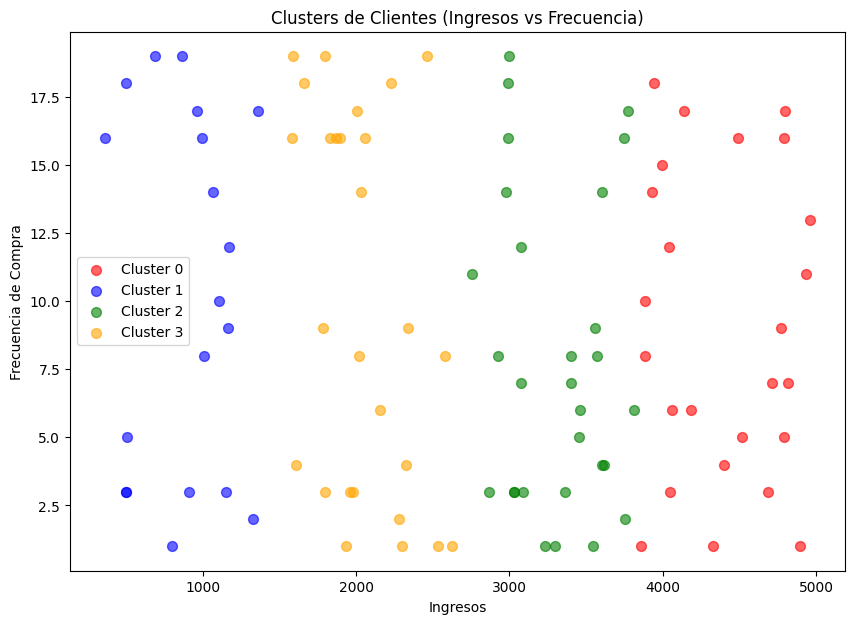

In [10]:
import matplotlib.pyplot as plt

# Convertir Spark DataFrame a Pandas
pred_pd = predicciones.select("ingresos", "frecuencia_compra", "cluster").toPandas()

# Colores para cada cluster
colors = ['red', 'blue', 'green', 'orange']

# Graficar cada cluster
plt.figure(figsize=(10,7))
for cluster in pred_pd['cluster'].unique():
    subset = pred_pd[pred_pd['cluster'] == cluster]
    plt.scatter(subset['ingresos'], subset['frecuencia_compra'],
                s=50, c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)

# Etiquetas y título
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia de Compra')
plt.title('Clusters de Clientes (Ingresos vs Frecuencia)')
plt.legend()
plt.show()


Insights

Cluster 0: Clientes de alto poder adquisitivo. Podrían recibir ofertas premium o productos exclusivos.

Cluster 1: Clientes frecuentes pero con ingresos bajos. Estrategia: descuentos, packs económicos o fidelización.

Cluster 2: Clientes estables y con ingresos medios-altos. Estrategia: promociones selectivas o productos complementarios.

Cluster 3: Jóvenes activos con ingresos medios. Estrategia: campañas dinámicas, marketing digital o combos atractivos.